**Introduction**
As part of Quantium’s retail analytics team, we were engaged by the Category Manager for Chips to gain a deeper understanding of customer purchasing behaviour within the chips category. The insights from this analysis will support the supermarket’s strategic planning for the upcoming half-year, helping inform decisions around product assortment, pricing, and targeted customer strategies.

**Objective**
*   Ensure transaction and customer
datasets are clean, consistent, and reliable
*   Understand customer demographics and purchasing patterns.
*  Understand customer demographics and purchasing patterns.
*   dentify key drivers of chip sales such as pack size, brand, and customer segment.
*   Generate actionable insights that
can be used commercially by the Category Manager.












In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
pd.set_option('display.max_rows', None)

In [4]:
PurchaseBehaviour = pd.read_csv('/content/QVI_purchase_behaviour.csv')
TransactionData = pd.read_excel('/content/QVI_transaction_data.xlsx')

In [5]:
display(PurchaseBehaviour.head())
display(TransactionData.head())

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


**Initial Data Validation**           
We begin by inspecting data types, missing values, and summary statistics to identify potential issues such as:
Incorrect data types,
Missing or null values and
Unusual ranges or extreme values

These checks ensure the dataset is reliable for downstream analysis.

In [6]:
TransactionData.info()
TransactionData.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,264836.000000,264836.00000,2.648360e+05,2.648360e+05,264836.000000,264836.000000,264836.000000
mean,43464.036260,135.08011,1.355495e+05,1.351583e+05,56.583157,1.907309,7.304200
std,105.389282,76.78418,8.057998e+04,7.813303e+04,32.826638,0.643654,3.083226
min,43282.000000,1.00000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000
25%,43373.000000,70.00000,7.002100e+04,6.760150e+04,28.000000,2.000000,5.400000
50%,43464.000000,130.00000,1.303575e+05,1.351375e+05,56.000000,2.000000,7.400000
75%,43555.000000,203.00000,2.030942e+05,2.027012e+05,85.000000,2.000000,9.200000
max,43646.000000,272.00000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


**Date Formatting**                     
The transaction date was originally stored as a numeric value.
This has been converted into a proper datetime format to enable:     
Time-based aggregation,
Monthly and daily trend analysis and
Accurate visualisation of sales over time

In [7]:
TransactionData["DATE"] = pd.to_datetime(
    TransactionData["DATE"], origin="1899-12-30", unit="D"
)
TransactionData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            264836 non-null  datetime64[ns]
 1   STORE_NBR       264836 non-null  int64         
 2   LYLTY_CARD_NBR  264836 non-null  int64         
 3   TXN_ID          264836 non-null  int64         
 4   PROD_NBR        264836 non-null  int64         
 5   PROD_NAME       264836 non-null  object        
 6   PROD_QTY        264836 non-null  int64         
 7   TOT_SALES       264836 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 16.2+ MB


**Exploring Product Information**     
Product names contain valuable information such as brand and pack size, but are unstructured text fields.
We analyse the text to:        
Identify non-chip products,
Understand common product attributes and
Prepare for feature extraction

In [8]:
TransactionData["PROD_NAME"].value_counts()



,count
PROD_NAME,
Kettle Mozzarella Basil & Pesto 175g,3304
Kettle Tortilla ChpsHny&Jlpno Chili 150g,3296
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g,3269
Tyrrells Crisps Ched & Chives 165g,3268
Cobs Popd Sea Salt Chips 110g,3265
Kettle 135g Swt Pot Sea Salt,3257
Tostitos Splash Of Lime 175g,3252
Infuzions Thai SweetChili PotatoMix 110g,3242
Smiths Crnkle Chip Orgnl Big Bag 380g,3233


In [9]:
unique_products = TransactionData["PROD_NAME"].unique()
words = []

for product in unique_products:
    words.extend(product.split())

productWords = pd.DataFrame(words, columns=["word"])

productWords = productWords[
    ~productWords["word"].str.contains(r"\d")
]

productWords = productWords[
    productWords["word"].str.contains(r"^[A-Za-z]+$")
]
productWords.value_counts()





,count
word,
Chips,21
Smiths,16
Crinkle,14
Cut,14
Kettle,13
Cheese,12
Salt,12
Original,10
Salsa,9


**Removing Non-Relevant Products**     
Salsa products are excluded from the dataset to ensure the analysis focuses solely on the chips category.
This improves accuracy when evaluating customer purchasing behaviour and category performance.

In [10]:
TransactionData["SALSA"] = TransactionData["PROD_NAME"].str.lower().str.contains("salsa")
TransactionData = TransactionData[TransactionData["SALSA"] == False]
TransactionData = TransactionData.drop(columns=["SALSA"])

In [11]:
TransactionData.describe(include='all')




,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742,246742.000000,246742.000000
unique,NaN,NaN,NaN,NaN,NaN,105,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Kettle Mozzarella Basil & Pesto 175g,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,3304,NaN,NaN
mean,2018-12-30 01:19:01.211467520,135.051098,1.355310e+05,1.351311e+05,56.351789,NaN,1.908062,7.321322
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,NaN,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,NaN,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,NaN,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,NaN,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,NaN,200.000000,650.000000


**Outlier Identification**    
A small number of transactions show unusually high purchase quantities (e.g. 200 units in a single transaction).                         
Investigation revealed these transactions belong to a single customer and are not representative of typical consumer behaviour.      
To avoid skewing results, these transactions are removed from the dataset.

In [12]:
TransactionData.isnull().sum()

,0
DATE,0
STORE_NBR,0
LYLTY_CARD_NBR,0
TXN_ID,0
PROD_NBR,0
PROD_NAME,0
PROD_QTY,0
TOT_SALES,0


In [13]:
TransactionData[TransactionData["PROD_QTY"] == 200]


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [14]:
outlier_customer = TransactionData.loc[
    TransactionData["PROD_QTY"] == 200, "LYLTY_CARD_NBR"
].iloc[0]

TransactionData[TransactionData["LYLTY_CARD_NBR"] == outlier_customer]


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [15]:
TransactionData =TransactionData[
    TransactionData["LYLTY_CARD_NBR"] != outlier_customer
]

In [16]:
TransactionData.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246740,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000
mean,2018-12-30 01:18:58.448569344,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000
std,NaN,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897


In [17]:
transactions_by_day = (
    TransactionData
    .groupby("DATE")
    .size()
    .reset_index(name="N")
)
print(transactions_by_day)


          DATE    N
0   2018-07-01  663
1   2018-07-02  650
2   2018-07-03  674
3   2018-07-04  669
4   2018-07-05  660
5   2018-07-06  711
6   2018-07-07  695
7   2018-07-08  653
8   2018-07-09  692
9   2018-07-10  650
10  2018-07-11  701
11  2018-07-12  717
12  2018-07-13  727
13  2018-07-14  661
14  2018-07-15  712
15  2018-07-16  678
16  2018-07-17  694
17  2018-07-18  689
18  2018-07-19  637
19  2018-07-20  684
20  2018-07-21  683
21  2018-07-22  673
22  2018-07-23  673
23  2018-07-24  648
24  2018-07-25  674
25  2018-07-26  672
26  2018-07-27  697
27  2018-07-28  640
28  2018-07-29  659
29  2018-07-30  692
30  2018-07-31  688
31  2018-08-01  680
32  2018-08-02  669
33  2018-08-03  662
34  2018-08-04  665
35  2018-08-05  705
36  2018-08-06  706
37  2018-08-07  668
38  2018-08-08  695
39  2018-08-09  652
40  2018-08-10  675
41  2018-08-11  678
42  2018-08-12  642
43  2018-08-13  703
44  2018-08-14  702
45  2018-08-15  702
46  2018-08-16  690
47  2018-08-17  663
48  2018-08-18  683


In [18]:
all_dates = pd.DataFrame({
    "DATE": pd.date_range("2018-07-01", "2019-06-30")
})


In [19]:
transactions_by_day = all_dates.merge(
    transactions_by_day, on="DATE", how="left"
)

transactions_by_day["N"] = transactions_by_day["N"].fillna(0)


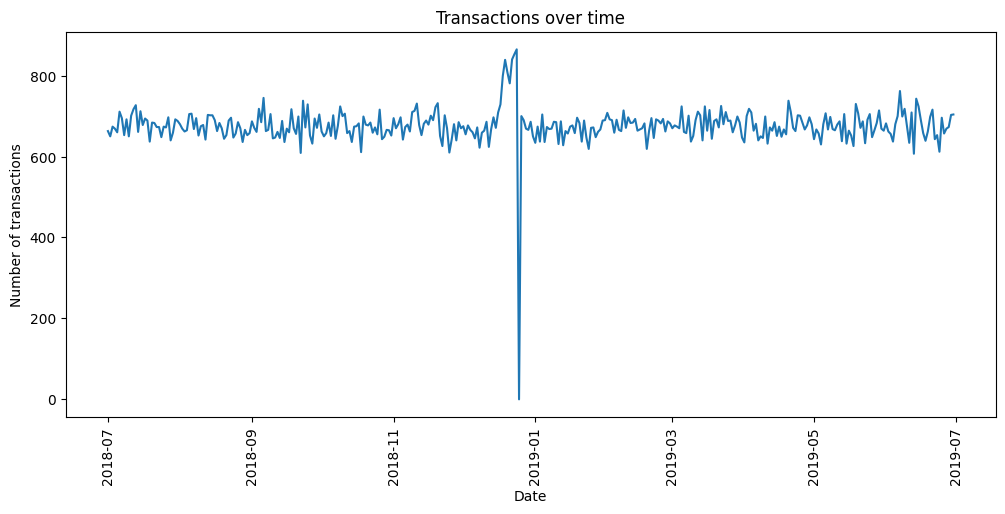

In [20]:
plt.figure(figsize=(12,5))
plt.plot(transactions_by_day["DATE"], transactions_by_day["N"])
plt.title("Transactions over time")
plt.xlabel("Date")
plt.ylabel("Number of transactions")
plt.xticks(rotation=90)
plt.show()


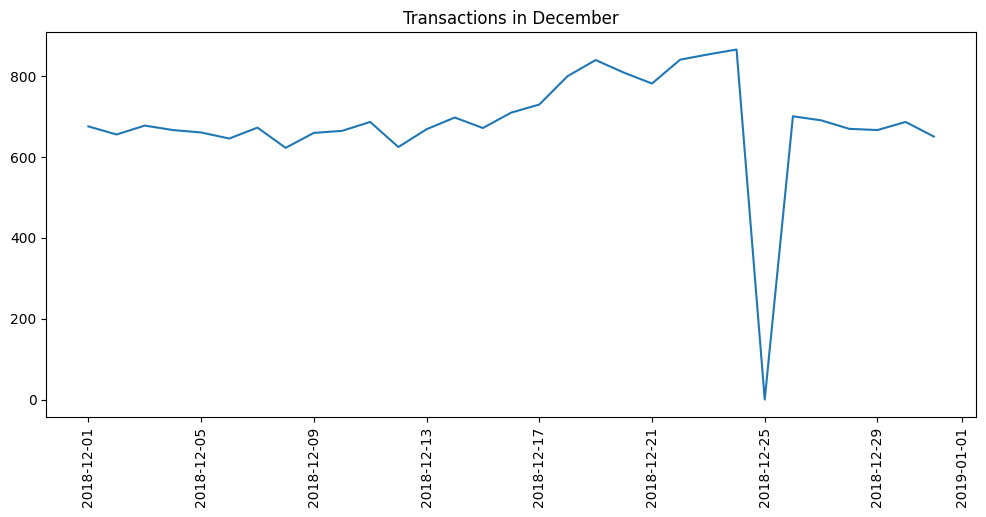

In [21]:
december = transactions_by_day[
    (transactions_by_day["DATE"] >= "2018-12-01") &
    (transactions_by_day["DATE"] <= "2018-12-31")
]

plt.figure(figsize=(12,5))
plt.plot(december["DATE"], december["N"])
plt.title("Transactions in December")
plt.xticks(rotation=90)
plt.show()


**Transaction Completeness**     
Daily transaction counts were analysed to identify missing dates.

One missing day was observed (December 25), which is likely due to store closures during public holidays.
This behaviour is expected and does not indicate a data issue.

**Deriving Pack Size**      
Pack size is extracted directly from product names using regular expressions.
This derived feature allows us to:
* Compare purchasing preferences across pack sizes
* Identify which pack sizes contribute most to total sales
* Support commercial decisions related to product assortment

In [22]:
TransactionData["PACK_SIZE"] = TransactionData["PROD_NAME"].str.extract(r"(\d+)").astype(int)
TransactionData["PACK_SIZE"].value_counts().sort_index()



,count
PACK_SIZE,
70,1507
90,3008
110,22387
125,1454
134,25102
135,3257
150,40203
160,2970
165,15297


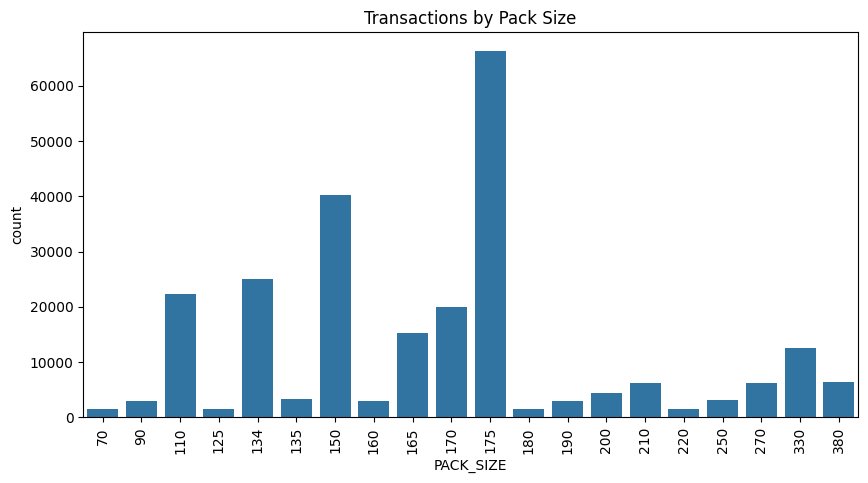

In [23]:
plt.figure(figsize=(10,5))
sns.countplot(x="PACK_SIZE", data=TransactionData)
plt.title("Transactions by Pack Size")
plt.xticks(rotation=90)
plt.show()

In [24]:
TransactionData["BRAND"] = TransactionData["PROD_NAME"].str.split().str[0]
TransactionData["BRAND"].value_counts()


,count
BRAND,
Kettle,41288
Smiths,27390
Pringles,25102
Doritos,22041
Thins,14075
RRD,11894
Infuzions,11057
WW,10320
Cobs,9693


In [25]:
TransactionData["BRAND"] = TransactionData["BRAND"].str.strip().str.upper()
TransactionData.loc[TransactionData["BRAND"] == "RED", "BRAND"] = "RRD"
TransactionData.loc[TransactionData["BRAND"] == "DORITO", "BRAND"] = "DORITOS"
TransactionData.loc[TransactionData["BRAND"] == "SMITH", "BRAND"] = "SMITHS"
TransactionData.loc[TransactionData["BRAND"] == "INFZNS", "BRAND"] = "INFUZIONS"
TransactionData.loc[TransactionData["BRAND"] == "SNBTS", "BRAND"] = "SUNBITES"

**Standardising Brand Names**   
Brand names are extracted from product names and standardised to ensure consistency.
Similar brand variations (e.g. Smith vs Smiths) are merged to prevent fragmentation in analysis and reporting.

In [26]:
TransactionData["BRAND"].value_counts()

,count
BRAND,
KETTLE,41288
SMITHS,30353
DORITOS,25224
PRINGLES,25102
RRD,16321
INFUZIONS,14201
THINS,14075
WW,10320
COBS,9693


In [27]:
PurchaseBehaviour.head()
PurchaseBehaviour.info()
PurchaseBehaviour.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
count,7.263700e+04,72637,72637
unique,NaN,7,3
top,NaN,RETIREES,Mainstream
freq,NaN,14805,29245
mean,1.361859e+05,NaN,NaN
std,8.989293e+04,NaN,NaN
min,1.000000e+03,NaN,NaN
25%,6.620200e+04,NaN,NaN
50%,1.340400e+05,NaN,NaN
75%,2.033750e+05,NaN,NaN


**Merging the Transaction & Customer Data**                    
After completing data cleaning and validation, the transaction and customer datasets were merged to create a unified dataset for analysis. This ensured that all transactional records were accurately enriched with corresponding customer attributes.

In [28]:
data = TransactionData.merge(
    PurchaseBehaviour,
    on="LYLTY_CARD_NBR",
    how="left"
)
data.isnull().sum()

,0
DATE,0
STORE_NBR,0
LYLTY_CARD_NBR,0
TXN_ID,0
PROD_NBR,0
PROD_NAME,0
PROD_QTY,0
TOT_SALES,0
PACK_SIZE,0
BRAND,0


In [29]:
data.to_csv("QVI_data.csv", index=False)

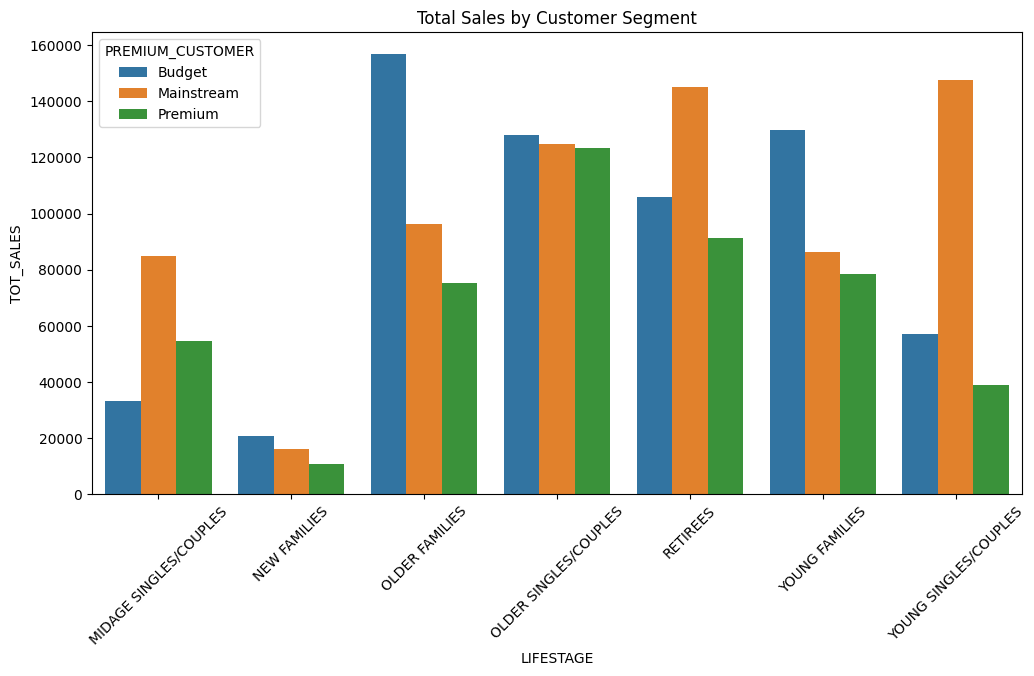

In [30]:
SalesBySegment = (
    data
    .groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["TOT_SALES"]
    .sum()
    .reset_index()
)
plt.figure(figsize=(12,6))
sns.barplot(
    data=SalesBySegment,
    x="LIFESTAGE",
    y="TOT_SALES",
    hue="PREMIUM_CUSTOMER"
)
plt.xticks(rotation=45)
plt.title("Total Sales by Customer Segment")
plt.show()


**Sales Contribution by Customer Segment**                  
This analysis examines total chip sales across customer segments defined by Life Stage and Premium Customer status. By aggregating total sales at the segment level, we identify which customer groups contribute the most revenue to the chips category.

The results show that mainstream young singles/couples and budget older families generate the highest overall sales. This suggests that these segments represent the core revenue base for the category and should be prioritised in strategic planning.

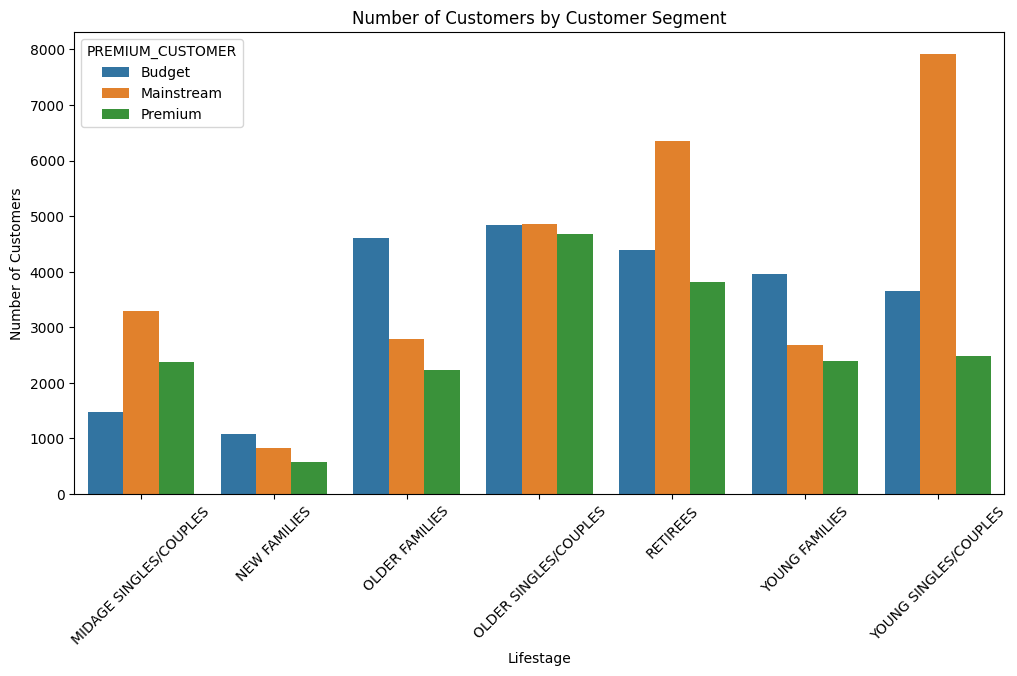

In [31]:
CustomersBySegment = (
    data
    .groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["LYLTY_CARD_NBR"]
    .nunique()
    .reset_index(name="NUM_CUSTOMERS")
)
plt.figure(figsize=(12,6))
sns.barplot(
    data=CustomersBySegment,
    x="LIFESTAGE",
    y="NUM_CUSTOMERS",
    hue="PREMIUM_CUSTOMER"
)
plt.xticks(rotation=45)
plt.title("Number of Customers by Customer Segment")
plt.ylabel("Number of Customers")
plt.xlabel("Lifestage")
plt.show()


**Customer Distribution Across Segments**                  
While total sales provide revenue insight, understanding the number of customers in each segment helps distinguish whether sales are driven by a large customer base or higher spending per customer.

The analysis reveals that mainstream customers dominate in volume, particularly within young singles/couples life stage.

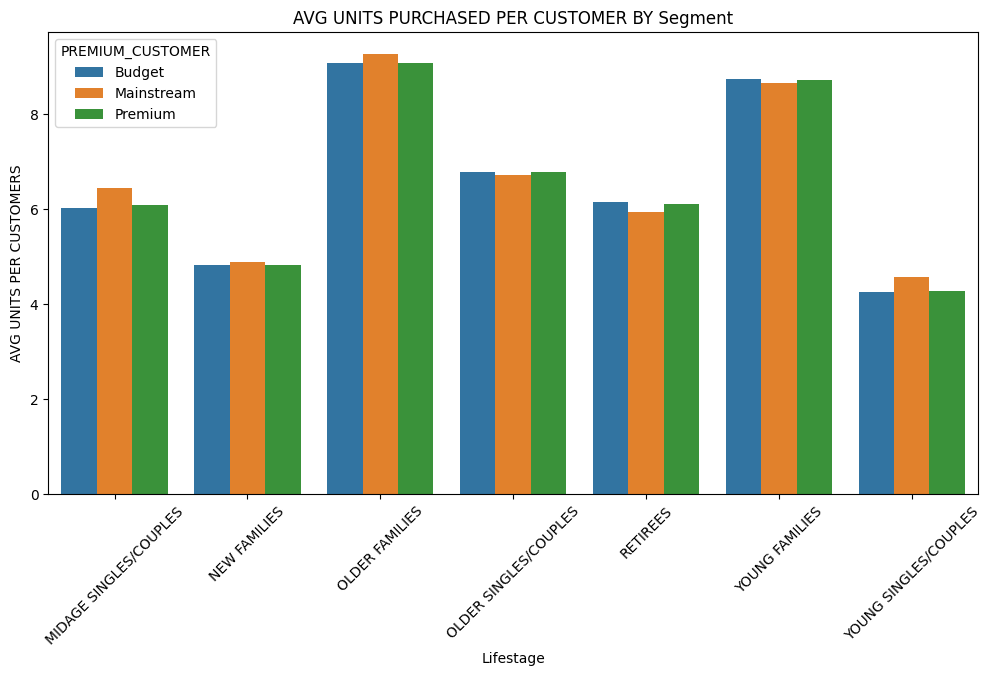

In [32]:
units_per_customer = (
    data
    .groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["PROD_QTY"]
    .sum()
    .reset_index()
    .merge(CustomersBySegment)
)

units_per_customer["AVG_UNITS"] = (
    units_per_customer["PROD_QTY"] /
    units_per_customer["NUM_CUSTOMERS"]
)
plt.figure(figsize=(12,6))
sns.barplot(
    data=units_per_customer,
    x="LIFESTAGE",
    y="AVG_UNITS",
    hue="PREMIUM_CUSTOMER"
)
plt.xticks(rotation=45)
plt.title("AVG UNITS PURCHASED PER CUSTOMER BY Segment")
plt.ylabel("AVG UNITS PER CUSTOMERS")
plt.xlabel("Lifestage")
plt.show()

**Units Purchased per Customer**   
This metric evaluates purchasing intensity by measuring the average number of chip units purchased per customer across segments.

It is clearly evident that people from all three segments, budget, mainstream and premium, buy almost the same number of units across all lifestages. However, highest number of chip packets are being purchased by older and young families.

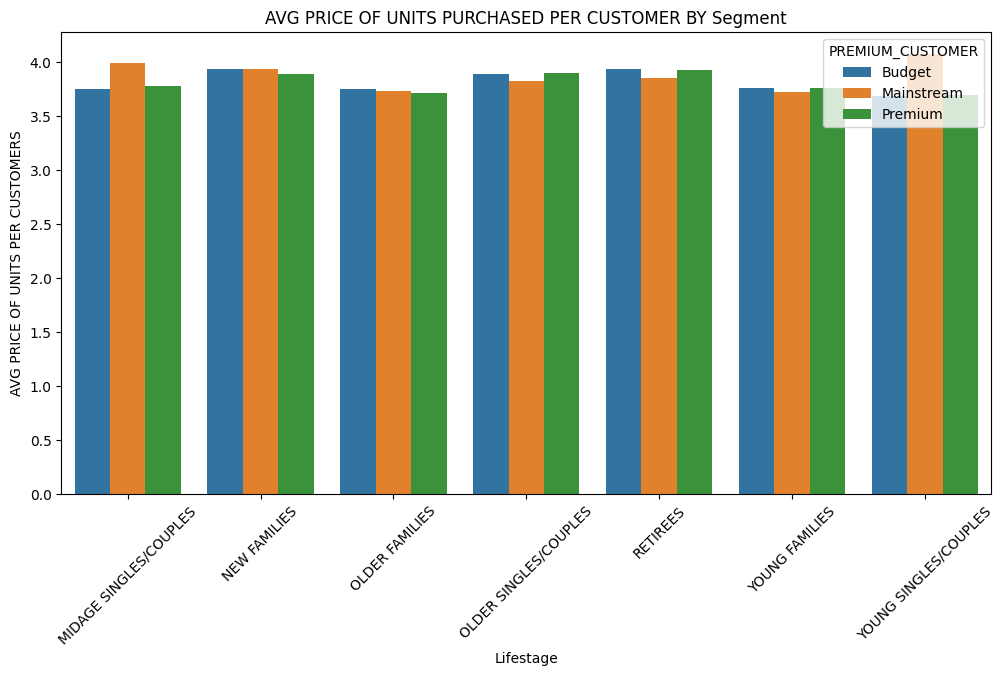

In [33]:

avg_price = (
    data
    .groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])
    .agg(AVG_PRICE=("TOT_SALES", lambda x: x.sum() / data.loc[x.index, "PROD_QTY"].sum()))
    .reset_index()
)
plt.figure(figsize=(12,6))
sns.barplot(
    data=avg_price,
    x="LIFESTAGE",
    y="AVG_PRICE",
    hue="PREMIUM_CUSTOMER"
)
plt.xticks(rotation=45)
plt.title("AVG PRICE OF UNITS PURCHASED PER CUSTOMER BY Segment")
plt.ylabel("AVG PRICE OF UNITS PER CUSTOMERS")
plt.xlabel("Lifestage")
plt.show()


In [34]:
from scipy.stats import ttest_ind

mainstream = data[
    (data["PREMIUM_CUSTOMER"] == "Mainstream") &
    (data["LIFESTAGE"].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"]))
]["TOT_SALES"]

premium = data[
    (data["PREMIUM_CUSTOMER"].isin(["Premium", "Budget"])) &
    (data["LIFESTAGE"].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"]))
]["TOT_SALES"]

ttest_ind(mainstream, premium, equal_var=False)


TtestResult(statistic=np.float64(33.06748508665197), pvalue=np.float64(1.834645908180742e-237), df=np.float64(55259.62579336254))

**Statistical Validation of Segment Differences**    
A t-test was conducted to evaluate whether observed differences in spending between customer segments are statistically significant rather than due to random variation.

Results confirm that mainstream and premium customers spend significantly more on chips than budget customers, reinforcing the validity of the segment-level insights observed in the descriptive analysis.

In [35]:
target = data[
    (data["PREMIUM_CUSTOMER"] == "Mainstream") &
    (data["LIFESTAGE"] == "YOUNG SINGLES/COUPLES")
]
display( target["BRAND"].value_counts(normalize=True))
display(target["PACK_SIZE"].value_counts(normalize=True))


,proportion
BRAND,
KETTLE,0.196684
DORITOS,0.121725
PRINGLES,0.118451
SMITHS,0.098291
INFUZIONS,0.063958
THINS,0.059660
TWISTIES,0.046050
TOSTITOS,0.045538
RRD,0.044771


,proportion
PACK_SIZE,
175,0.255679
150,0.157593
134,0.118451
110,0.104943
170,0.080587
330,0.061144
165,0.056386
380,0.032030
270,0.031723


In [36]:
target2 = data[
    (data["PREMIUM_CUSTOMER"] == "Mainstream") &
    (data["LIFESTAGE"] == "MIDAGE SINGLES/COUPLES")
]
display(target2["BRAND"].value_counts(normalize=True))
display(target2["PACK_SIZE"].value_counts(normalize=True))




,proportion
BRAND,
KETTLE,0.192519
SMITHS,0.115007
DORITOS,0.109058
PRINGLES,0.104461
INFUZIONS,0.061199
THINS,0.057233
RRD,0.055070
COBS,0.044615
TWISTIES,0.044164


,proportion
PACK_SIZE,
175,0.268139
150,0.160162
134,0.104461
110,0.101307
170,0.079495
330,0.060207
165,0.057774
270,0.030915
380,0.027941


**Brand and Pack Size Preferences**   
A focused analysis was conducted on young and mid-age couples, as these segments contribute substantially to overall sales.

Results show a strong preference for well-established brands and medium to large pack sizes, suggesting that these customers value familiarity and convenience. Smaller pack sizes are less popular within these groups, indicating lower price sensitivity and a preference for perceived value over cost minimisation.

**Conclusion – Customer Purchasing Behaviour**

The analysis reveals that chip sales are driven primarily by young and mid-age mainstream and premium customers, who exhibit higher spending, greater purchase frequency, and a preference for established brands and larger pack sizes. While budget customers contribute to volume, their overall revenue impact is comparatively lower due to reduced spend per unit.

These insights suggest that the greatest growth opportunity lies in targeting high-value customer segments through tailored product assortments, pricing strategies, and in-store visibility. By aligning category strategy with customer behaviour, the supermarket can maximise returns while strengthening customer engagement within the chips category.